In [1]:
import os

import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

In [2]:
from data_loader import load_dataset, batch_dataset

# Load Test Data

Images in the `valid` folder are to be used as test images. Note that these images were not used as validation set during training, or touched in any way before testing.

In [3]:
DATA_DIR = 'data/agegender_cleaned/'
data_files = os.path.join(DATA_DIR, 'valid/*/*.jpg')

In [4]:
CLASS_NAMES = tf.constant(['F', 'M'])
IMAGE_SIZE = 224
BATCH_SIZE = 32

In [5]:
test_ds = load_dataset(data_files, IMAGE_SIZE, CLASS_NAMES)
test_ds = batch_dataset(test_ds)

# Load VGG_FACE

Load trained model.

In [6]:
TUNED_MODEL = 'C:/Users/ZHOU/Work/Code/external/VGG_face_gender/saved_models/VGG_FACE_gender/'

VGG_face_gender = tf.keras.models.load_model(TUNED_MODEL)

# Testing on Gender Dataset

Run prediction.

In [9]:
def test_accuracy(dataset):
    accuracy = tf.keras.metrics.BinaryAccuracy()
    auc = tf.keras.metrics.AUC()
    for image_batch, label_batch in dataset:
        pred_batch = VGG_face_gender.predict(image_batch)
        _ = accuracy.update_state(label_batch, pred_batch.squeeze(-1))
        _ = auc.update_state(label_batch, pred_batch.squeeze(-1))
    return accuracy, auc

Compute binary classification accuracy.

In [10]:
accuracy, auc = test_accuracy(test_ds)

print("Prediction accuracy on test set (threshold = 0.5):", accuracy.result().numpy())
print("AUC of ROC curve:", auc.result().numpy())

Prediction accuracy on test set (threshold = 0.5): 0.95258623
AUC of ROC curve: 0.99147666


# Visualization

## See prediction labels on images

Showiing predicted labels on a random sample of images.

In [11]:
image_batch, label_batch = next(iter(test_ds))
pred_batch = VGG_face_gender.predict(image_batch)

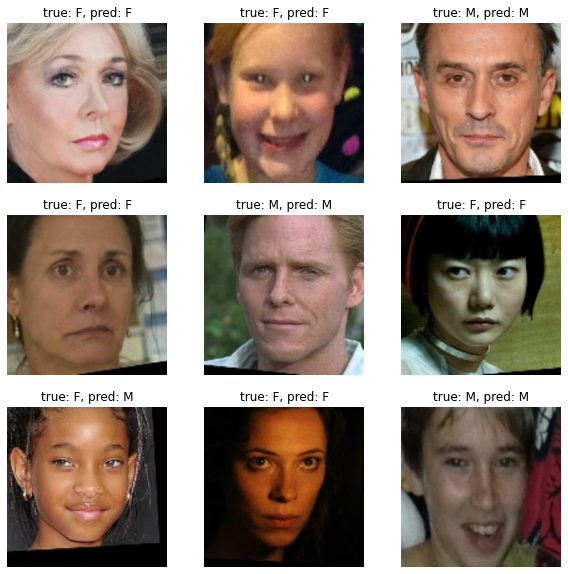

In [12]:
class_labels = CLASS_NAMES.numpy().astype('str')
pred_gender_batch = class_labels[(pred_batch.squeeze() > 0.5).astype(np.uint)]
gender_batch = class_labels[label_batch]

fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for i in range(9):
    ax = axes[i//3][i%3]
    ax.imshow(image_batch[i].numpy().astype(np.uint8))
    ax.set_title(f'true: {gender_batch[i]}, pred: {pred_gender_batch[i]}')
    ax.axis('off')

## Accuracy by age group

In [13]:
data_pattern_by_age = [f'valid/{i}?_?/*.jpg' for i in range(8)]
data_pattern_by_age = [os.path.join(DATA_DIR, pattern) for pattern in data_pattern_by_age]

In [16]:
accuracy_by_age = []
for i, age_group in enumerate(data_pattern_by_age):
    test_ds_age = load_dataset(age_group, IMAGE_SIZE, CLASS_NAMES)
    test_ds_age = batch_dataset(test_ds_age)
    accuracy_age, _ = test_accuracy(test_ds_age)
    accuracy_age = accuracy_age.result().numpy()
    accuracy_by_age.append(accuracy_age)
    print(f"Age group {i*10}-{i*10+9} accuracy: {accuracy_age:.4f}")

Age group 0-9 accuracy: 0.8711
Age group 10-19 accuracy: 0.9094
Age group 20-29 accuracy: 0.9669
Age group 30-39 accuracy: 0.9757
Age group 40-49 accuracy: 0.9913
Age group 50-59 accuracy: 0.9621
Age group 60-69 accuracy: 0.9843
Age group 70-79 accuracy: 0.9844
